In [2]:
from FlagEmbedding import FlagModel
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pprint import pprint as pp
import time
import umap
import os
import random
import time
from contextlib import contextmanager

@contextmanager
def timer():
    start_time = time.time()
    try:
        yield
    finally:
        end_time = time.time()
        print(f"Elapsed time: {end_time - start_time:.4f} seconds")
model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="",
                  use_fp16=True)
from datasets import load_dataset, load_from_disk
from datasets import load_dataset, concatenate_datasets, load_from_disk
import pandas as pd
import datasets
from datasets import Dataset
from pprint import pprint as pp
from datasets import Dataset
from sklearn.cluster import KMeans
from tqdm import tqdm
import torch
import heapq
code_data = load_dataset("sahil2801/CodeAlpaca-20k")["train"]
fin_data = load_dataset("FinGPT/fingpt-sentiment-train")["train"]
med_data = load_dataset("medalpaca/medical_meadow_medical_flashcards")["train"]
general_data = load_dataset("tatsu-lab/alpaca")["train"]
math_data = load_dataset("TIGER-Lab/MathInstruct")["train"]
def alpaca_format(example):
    if example['input'] == "":
        example["instruction"] = example["instruction"]
    else:
        example["instruction"] = example["instruction"] + " " + example['input']
    example["response"] = example['output']
    return example
def process_sft_dataset(dataset_name, dataset, dataset_sample=None)->datasets.Dataset:
    if dataset_name in ["lucasmccabe-lmi/CodeAlpaca-20k", "yahma/alpaca-cleaned", "FinGPT/fingpt-sentiment-train"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["WizardLM/WizardLM_evol_instruct_70k"]:
        dataset = dataset.rename_column("output", "response")
    elif dataset_name in ["tatsu-lab/alpaca", "vicgalle/alpaca-gpt4", "gbharti/finance-alpaca"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output', 'text'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["TIGER-Lab/MathInstruct"]:
        df = pd.DataFrame(dataset)
        df = df.drop_duplicates(subset=['instruction'])
        dataset = datasets.Dataset.from_pandas(df)
        dataset = dataset.rename_column("output", "response")
        dataset = dataset.remove_columns(['source'])
    elif dataset_name in ["lighteval/MATH"]:
        dataset = dataset.rename_column("solution", "response")
        dataset = dataset.rename_column("problem", "instruction")
        dataset = dataset.remove_columns(['level', 'type'])
    elif dataset_name in ['gsm8k']:
        dataset = dataset.rename_column("question", "instruction")
        dataset = dataset.rename_column("answer", "response")
    elif dataset_name in ['medalpaca/medical_meadow_medical_flashcards']:       # TODO: 'lavita/ChatDoctor-HealthCareMagic-100k'. not sure whether to discard the instruction.
        dataset = dataset.remove_columns(['instruction'])
        dataset = dataset.rename_column("input", "instruction")
        dataset = dataset.rename_column("output", "response")
    elif "math" in dataset_name:
        dataset = dataset.remove_columns(['source'])
        dataset = dataset.rename_column("output", "response")
    else:
        raise NotImplementedError(f"Dataset {dataset_name} is not supported.")
    dataset = dataset.shuffle(seed=2023)
    if dataset_sample:
        num_sample = min(len(dataset), dataset_sample)
        dataset = dataset.select(range(num_sample))
    print(f">> ===== After processing, Dataset {dataset_name} has {len(dataset)} examples. =====")
    return dataset
processed_data = []
for name, dataset in zip(["lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards","tatsu-lab/alpaca","TIGER-Lab/MathInstruct"],[code_data,fin_data,med_data,general_data,math_data]):
# for name, dataset in zip(["lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards", "TIGER-Lab/MathInstruct"],[code_data,fin_data,med_data,math_data]):
    tmp:datasets.Dataset = process_sft_dataset(name,dataset)
    print(tmp.column_names)
    processed_data.append(tmp)
def labeling(example, label):
    example["label"] = label
    return example
label = ["code","fin","med", "gen", "math"]

for i, data in enumerate(processed_data):
    data = data.map(lambda example: labeling(example, label[i]), batched=False)
    processed_data[i] = data
data_concated:Dataset = concatenate_datasets(processed_data)

----------using 8*GPUs----------
>> ===== After processing, Dataset lucasmccabe-lmi/CodeAlpaca-20k has 20022 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset FinGPT/fingpt-sentiment-train has 76772 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset medalpaca/medical_meadow_medical_flashcards has 33955 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset tatsu-lab/alpaca has 52002 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset TIGER-Lab/MathInstruct has 224567 examples. =====
['response', 'instruction', '__index_level_0__']


Map:   0%|          | 0/224567 [00:00<?, ? examples/s]

In [3]:
public_datasets = []
for i in range(10):
    tmp = data_concated.shard(10,i)
    idx = random.sample(range(len(tmp)),5100)
    public_datasets.append(tmp.select(idx))

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Inference Embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


<Figure size 640x480 with 0 Axes>

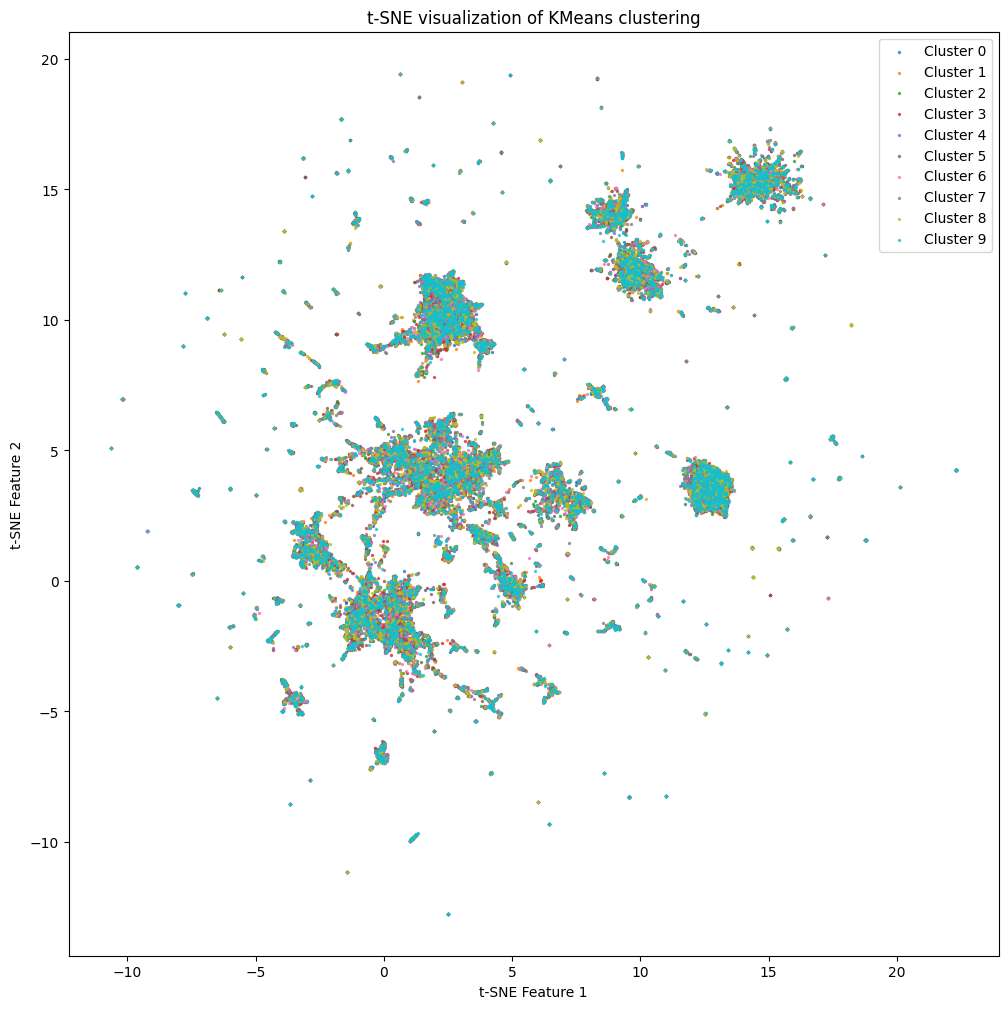

In [4]:
for i, pos_data in enumerate(public_datasets):
    pos_data.save_to_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/iid_pos_public_{i}.parquet")
root = "/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/"
datas = []
for i in range(10):
    datas.append(load_from_disk(f"{root}/iid_pos_public_{i}.parquet"))

# 遍历数据并进行 t-SNE 可视化
embeddings = []
labels = []
for i, data in enumerate(datas):
    embedding = model.encode(data["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

embeddings = np.array(embeddings)
labels = np.array(labels)
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 调整子图间距
plt.tight_layout()
# 展示所有子图
plt.show()

plt.figure(figsize=(12, 12))
for i in range(10):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()